# Processing

Creates an adata object from the output of the single-cell proteomics R pipeline.

In [1]:
import pyreadr
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
PATH = "../Code/_targets/objects/dat_SN_maxLFQ_m"

In [3]:
raw = pyreadr.read_r(PATH)

In [25]:
table = raw[None]
table.columns = table.columns.str.lower()

Create intensitry matrix.

In [27]:
row_name = "run_chan"
col_name = "genes"
value_name = "value"

rows = table[row_name].unique()
cols = table[col_name].unique()

print(f"Rows: {len(rows)}, Cols: {len(cols)}")

Rows: 528, Cols: 1690


In [28]:
data = np.full((len(rows), len(cols)), np.nan)

df = pd.DataFrame(data, index=rows, columns=cols)

for i, row in table.iterrows():
    df.at[row[row_name], row[col_name]] = row[value_name]

In [29]:
df.head()

,SRP14,RPL4,EXOSC10,DOCK2,ARID1A,CHCHD3,MED17,NCL,SND1,INTS1,...,ZNF593,HDAC1,HDAC2,EFCAB5,RPL26L1,YWHAE,YWHAG,BCKDK,TEX44,RBM3
gJD3310_B.A1_1_3580mTRAQ0,166.068188,12036.398779,4942.138537,1708.717340,2814.724901,9127.889435,647.716003,25212.128698,9099.061566,2992.496941,...,NaN,NaN,NaN,30.313638,NaN,NaN,81.941118,127.981932,7558.562064,2445.113416
gJD3312_B.A3_1_3582mTRAQ0,1234.788516,2122.531250,2006.970123,1293.069695,1043.999361,2311.015959,4206.377325,10939.742511,4075.373146,2312.445797,...,1440.598576,610.744628,NaN,NaN,NaN,NaN,332.701871,NaN,2472.685355,711.695525
gJD3313_B.A4_1_3583mTRAQ0,1576.352170,5592.304934,3918.499176,979.922802,1714.338065,5565.918438,NaN,18829.514765,5601.525917,3601.262897,...,314.021967,NaN,NaN,206.204369,NaN,NaN,NaN,236.438031,4022.725033,791.510046
gJD3314_B.A5_1_3584mTRAQ0,1911.434680,3068.140349,2186.421374,2355.815439,589.733761,4496.846875,262.310997,11397.909978,5909.710607,3314.069122,...,NaN,NaN,NaN,NaN,NaN,169.459344,529.131505,NaN,2277.256667,806.961110
gJD3315_B.A6_1_3585mTRAQ0,1474.594609,6734.457791,2055.501688,1529.575335,857.972329,8012.798247,476.134945,21403.164330,7628.291260,1615.320522,...,370.829358,NaN,NaN,581.946828,NaN,NaN,1364.441086,89.952708,3864.950560,25.735222


Create obs table.

In [33]:
table = table.set_index(row_name)

obs_table = table[~table.index.duplicated(keep='first')]
obs_table = obs_table[["celltype", "label", "run", "lc_batch", "biorep", "carrier_amount"]]

In [35]:
obs_table.head()

,celltype,label,run,lc_batch,biorep,carrier_amount
run_chan,,,,,,
gJD3310_B.A1_1_3580mTRAQ0,NUC_10,0,3580,7,3,25
gJD3312_B.A3_1_3582mTRAQ0,NUC_60,0,3582,7,3,25
gJD3313_B.A4_1_3583mTRAQ0,NUC_30,0,3583,7,3,25
gJD3314_B.A5_1_3584mTRAQ0,NUC_10,0,3584,7,3,25
gJD3315_B.A6_1_3585mTRAQ0,NUC_NT,0,3585,7,3,25


Create var table.

In [36]:
table = table.set_index(col_name)

var_table = table[~table.index.duplicated(keep='first')]
var_table = var_table[["gene"]]

var_table.columns = [col.lower() for col in var_table.columns]


In [37]:
var_table.head()

,gene
genes,
SRP14,SRP14
RPL4,RPL4
EXOSC10,EXOSC10
DOCK2,DOCK2
ARID1A,ARID1A


Create anndata object.

In [38]:
adata = sc.AnnData(X=df, obs=obs_table, var=var_table)

sc.pp.log1p(adata, base=2)
adata.layers["raw"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
sc.tl.pca(adata)

/home/rasmus/rmls/work/ra/leduc2024/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:384: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [39]:
adata

AnnData object with n_obs × n_vars = 528 × 1690
    obs: 'celltype', 'label', 'run', 'lc_batch', 'biorep', 'carrier_amount'
    var: 'gene'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [40]:
adata.write("leduc_2024.h5ad")

In [19]:
adata

AnnData object with n_obs × n_vars = 528 × 1690
    obs: 'Celltype', 'Label', 'run', 'LC_batch', 'BioRep', 'Carrier_amount'
    var: 'Gene'
    uns: 'log1p'
    layers: 'raw'

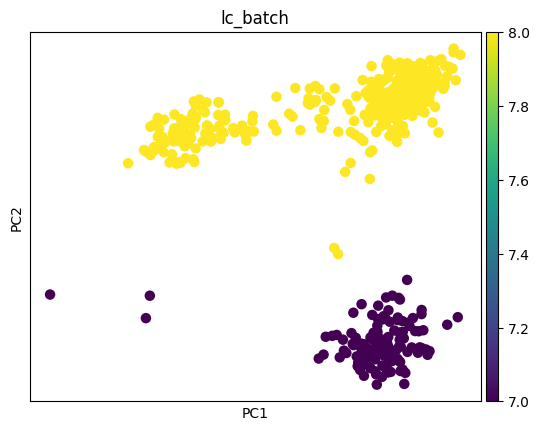

In [43]:
sc.pl.pca(adata, color=["lc_batch"])